In [1]:
import os
import json
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt

import pytorch_lightning as pl

random_seed = 1337
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
train_ratio = 0.8  # 80% for training, 20% for validation

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

print(NUM_WORKERS)
print(AVAIL_GPUS)

8
1


In [2]:
json_dir = '../learning-data/'

all_segments = []
all_grass_positions = []
all_starting_points = []

# Helper function to compute length and angle
def compute_length_and_angle(x1, y1, x2, y2):
    length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    angle = np.arctan2(y2 - y1, x2 - x1)
    return length, angle

# Iterate through JSON files
for filename in os.listdir(json_dir):
    if filename.endswith('.json'):
        with open(os.path.join(json_dir, filename), 'r') as f:
            ground_data = json.load(f)
            segments = ground_data['segments']
            grass_positions = ground_data['grassPositions']
            # check if ground data contains starting point
            if 'startingPoint' in ground_data:
                starting_point = ground_data['startingPoint']
            else:
                starting_point = all_starting_points[-1]

            # Append data to lists
            all_segments.append(segments)
            all_grass_positions.append(grass_positions)
            all_starting_points.append(starting_point)

In [3]:
segments_list = []
for segment in all_segments:
    #segment_tensor = torch.tensor([[point['x'], point['y'], point['length'], point['angleToNextVector']] for point in segment], dtype=torch.float32)
    #segment_tensor = torch.tensor([[point['x'], point['y']] for point in segment], dtype=torch.float32)
    segment_tensor = torch.tensor([[point['length'], point['angleToNextVector']] for point in segment], dtype=torch.float32)
    segments_list.append(segment_tensor)
segments_tensor = torch.stack(segments_list)
print(segments_tensor)

# Convert grass positions to tensor
grass_positions_tensor = torch.tensor(all_grass_positions, dtype=torch.int64)  # Assuming grass positions are integers

# Convert starting points to tensor
starting_points_tensor = torch.tensor(all_starting_points, dtype=torch.float32)


In [4]:
train_size = int(len(segments_tensor) * train_ratio)  # % for training
val_size = len(segments_tensor) - train_size  # Remaining % for validation

# Split the data into training and validation sets
train_dataset, val_dataset = random_split(segments_tensor, [train_size, val_size])

# Create DataLoader instances for training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Optionally, you can print the sizes of the datasets
print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))

Training dataset size: 816
Validation dataset size: 205


In [5]:
# Define the discriminator model with dropout
class FNNDiscriminator(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size, dropout_prob=0.8):
        super(FNNDiscriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.dropout(self.relu(self.fc4(x)))
        x = self.sigmoid(self.fc5(x))
        return x

# Define the generator model with dropout
class LSTMGenerator(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size, dropout_prob=0.8):
        super(LSTMGenerator, self).__init__()
        self.hidden_size1 = hidden_size1
        self.lstm = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.fc1 = nn.Linear(hidden_size1, hidden_size2)
        self.fc2 = nn.Linear(hidden_size2, hidden_size3)
        self.fc3 = nn.Linear(hidden_size3, hidden_size4)
        self.fc4 = nn.Linear(hidden_size4, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size1).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size1).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        
        out = out[:, -1, :]  # Take the output from the last time step
        
        out = self.dropout(self.relu(self.fc1(out)))
        out = self.dropout(self.relu(self.fc2(out)))
        out = self.dropout(self.relu(self.fc3(out)))
        out = self.fc4(out)
        return out

In [6]:
# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
input_size_discriminator = 1710  # Input size should match the length of each segment for x and y only
hidden_size_discriminator1 = 512
hidden_size_discriminator2 = 256
hidden_size_discriminator3 = 128
hidden_size_discriminator4 = 64
output_size_discriminator = 1

input_size_generator = 64
hidden_size_generator1 = 128
hidden_size_generator2 = 256
hidden_size_generator3 = 512
hidden_size_generator4 = 1024
output_size_generator = 1710  # Output size should match the size of each segment for x and y only

    
discriminator = FNNDiscriminator(input_size_discriminator, hidden_size_discriminator1,
                                  hidden_size_discriminator2, hidden_size_discriminator3,
                                  hidden_size_discriminator4,
                                  output_size_discriminator).to(device)
generator = LSTMGenerator(input_size_generator, hidden_size_generator1, hidden_size_generator2, hidden_size_generator3, hidden_size_generator4, output_size_generator).to(device)

criterion = nn.BCELoss().to(device)  # Binary Cross-Entropy Loss
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.00001, betas=(0.65, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.00001, betas=(0.65, 0.999))

def gradient_penalty(discriminator, real_data, fake_data):
    batch_size = real_data.size(0)
    epsilon = torch.rand(batch_size, 1, 1).to(real_data.device)
    epsilon = epsilon.expand_as(real_data)

    interpolated = epsilon * real_data + (1 - epsilon) * fake_data
    interpolated = torch.autograd.Variable(interpolated, requires_grad=True)

    interpolated_prob = discriminator(interpolated)

    gradients = torch.autograd.grad(
        outputs=interpolated_prob,
        inputs=interpolated,
        grad_outputs=torch.ones(interpolated_prob.size()).to(real_data.device),
        create_graph=True,
        retain_graph=True
    )[0]

    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    return ((gradient_norm - 1) ** 2).mean()

def wasserstein_loss(D_real, D_fake):
    return D_fake.mean() - D_real.mean()

def length_penalty_loss(flat_fake_data, batch_size):
    lengths = flat_fake_data.view(batch_size, -1, 2)[:, :, 0]  # Extract length values
    # Calculate absolute difference for each length from 0.5 and apply ReLU
    penalty = torch.relu(torch.abs(lengths - 0.5))
    # Sum the penalties
    penalty = torch.sum(penalty)
    return penalty

def angle_loss(angles):
    # Compute the differences between consecutive angles
    angle_diffs = angles[:, 1:] - angles[:, :-1]
    
    # Penalize sequences where the differences are consistently in the same direction
    max_allowed_diff = torch.deg2rad(torch.tensor(60.0)).to(angles.device)  # Maximum allowed deviation in radians
    
    # Penalize large positive and negative differences
    positive_penalty = torch.relu(angle_diffs - max_allowed_diff)
    negative_penalty = torch.relu(-angle_diffs - max_allowed_diff)
    
    # Sum up the penalties for all differences
    total_penalty = torch.sum(positive_penalty + negative_penalty)
    
    return total_penalty

def angle_range_penalty_loss(fake_data, min_angle=-45, max_angle=80):
    # Extract the angle values from the fake data
    angles = fake_data[:, 1]  # Assuming angles are the second component
    # Penalize angles outside the range [min_angle, max_angle]
    penalty_outside_range = torch.relu(min_angle - angles) + torch.relu(angles - max_angle)
    
    # Strongly penalize angles close to 0, 1, and -1 using exponential penalty
    penalty_near_zero = torch.exp(2 * torch.abs(angles))
    penalty_near_one = torch.exp(2 * torch.abs(angles - 1))
    
    # print("angles are", angles)
    # print("penalty_near_zero", penalty_near_zero)
    # print("penalty_near_one", penalty_near_one)
    
    
    # Reward angles that are close to min_angle or max_angle
    reward_near_min = torch.exp(-torch.pow((angles - min_angle) / (max_angle - min_angle), 2))
    reward_near_max = torch.exp(-torch.pow((angles - max_angle) / (max_angle - min_angle), 2))
    
    
    # Sum the penalties and rewards
    total_penalty = torch.sum(penalty_outside_range + penalty_near_zero + penalty_near_one)
    total_reward = torch.sum(reward_near_min + reward_near_max)
    
    # The final loss combines penalties and rewards
    total_loss = total_penalty - total_reward

    return total_loss


def length_difference_loss(real_lengths, fake_lengths):
    real_avg_length = torch.mean(real_lengths)
    fake_avg_length = torch.mean(fake_lengths)
    return torch.abs(real_avg_length - fake_avg_length)


def normalize_angles(angles, min_angle, max_angle):
    return (angles - min_angle) / (max_angle - min_angle)

def denormalize_angles(normalized_angles, min_angle, max_angle):
    return normalized_angles * (max_angle - min_angle) + min_angle



# Training loop
num_epochs = 350
lambda_penalty = 2.0  # Weight for the length penalty loss
lambda_difference = 5.0  # Weight for the length difference loss
lambda_angle = 15.0  # Weight for the angle penalty loss
lambda_angle_range = 12.0  # Weight for the angle range penalty loss

for epoch in range(num_epochs):
    for real_data in train_dataloader:
        real_data = real_data.float().to(device).view(real_data.size(0), -1)  # Flatten and move to GPU

        real_labels = torch.ones(len(real_data), 1).to(device)
        fake_labels = torch.zeros(len(real_data), 1).to(device)

        # Train discriminator
        real_output = discriminator(real_data)
        d_loss_real = criterion(real_output, real_labels)
        real_score = real_output

        z = torch.randn(len(real_data), input_size_generator).unsqueeze(1).repeat(1, 855, 1).to(device)  # Generate random noise
        fake_data = generator(z)
        fake_data = fake_data.view(fake_data.size(0), -1)  # Flatten the fake data

        fake_output = discriminator(fake_data)
        d_loss_fake = criterion(fake_output, fake_labels)
        fake_score = fake_output

        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train generator
        z = torch.randn(len(real_data), input_size_generator).unsqueeze(1).repeat(1, 855, 1).to(device)  # Generate random noise
        fake_data = generator(z)
        output = discriminator(fake_data.view(fake_data.size(0), -1))  # Flatten the fake data

        g_loss = criterion(output, real_labels)

        # Add the length penalty loss
        length_penalty = length_penalty_loss(fake_data, len(real_data))

        # Add the length difference loss
        real_lengths = torch.norm(real_data.view(len(real_data), -1, 2), dim=2)  # Calculate lengths for real data
        fake_lengths = torch.norm(fake_data.view(len(real_data), -1, 2), dim=2)  # Calculate lengths for fake data
        difference_loss = length_difference_loss(real_lengths, fake_lengths)
        
        # Add the angle penalty loss
        fake_angles = fake_data.view(len(real_data), 855, 2)[:, :, 1]  # Assuming angles are the second component
        angle_penalty = angle_loss(fake_angles)

        # Add the angle range penalty loss
        angle_range_penalty = angle_range_penalty_loss(fake_data)

        # Calculate the total generator loss
        # total_g_loss = g_loss + lambda_penalty * length_penalty + lambda_difference * difference_loss + lambda_angle * angle_penalty + lambda_angle_range * angle_range_penalty
        total_g_loss = g_loss + lambda_penalty * length_penalty + lambda_angle_range * angle_range_penalty

        g_optimizer.zero_grad()
        total_g_loss.backward()
        g_optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {total_g_loss.item():.4f}, length_penalty: {length_penalty.item():.4f}, difference_loss: {difference_loss.item():.4f}, angle_penalty: {angle_penalty.item():.4f}, angle_range_penalty: {angle_range_penalty.item():.4f}')


# Generate new data after training
z = torch.randn(1, input_size_generator).unsqueeze(1).repeat(1, 855, 1).to(device)  # Generate random noise
fake_data = generator(z)
fake_data = fake_data.view(fake_data.size(0), 855, 2)

generated_data = []

for sample in fake_data:
    segment_data = []
    for vector in sample:
        segment_data.append({
            "length": vector[0].item(),
            "angleToNextVector": vector[1].item()
        })
    generated_data.append({"segments": segment_data})

print(generated_data)

Epoch [1/350], d_loss: 5.0583, g_loss: 45149.1094, length_penalty: 20466.7070, difference_loss: 22.2572, angle_penalty: 0.0000, angle_range_penalty: 351.2494
Epoch [2/350], d_loss: 2.6673, g_loss: 44966.7461, length_penalty: 20344.2441, difference_loss: 22.4366, angle_penalty: 0.0000, angle_range_penalty: 356.4625
Epoch [3/350], d_loss: 3.3437, g_loss: 44462.7617, length_penalty: 20240.3496, difference_loss: 22.1928, angle_penalty: 0.0000, angle_range_penalty: 331.7801
Epoch [4/350], d_loss: 3.8358, g_loss: 43881.7539, length_penalty: 20057.3281, difference_loss: 22.4397, angle_penalty: 0.0000, angle_range_penalty: 313.8661
Epoch [5/350], d_loss: 4.1978, g_loss: 43635.2070, length_penalty: 19942.8281, difference_loss: 22.4387, angle_penalty: 0.0000, angle_range_penalty: 312.4030
Epoch [6/350], d_loss: 5.1348, g_loss: 43569.7773, length_penalty: 19884.7617, difference_loss: 22.3825, angle_penalty: 0.0000, angle_range_penalty: 316.6289
Epoch [7/350], d_loss: 3.7954, g_loss: 42876.0391, l

[{'segments': [{'length': 0.2370770275592804, 'angleToNextVector': 0.30567196011543274}, {'length': 0.3912952244281769, 'angleToNextVector': -0.054996177554130554}, {'length': 0.3744514584541321, 'angleToNextVector': 0.036507315933704376}, {'length': 0.3050425946712494, 'angleToNextVector': 0.13251474499702454}, {'length': 0.35608792304992676, 'angleToNextVector': -0.17812906205654144}, {'length': 0.35436147451400757, 'angleToNextVector': -0.040983010083436966}, {'length': 0.38737061619758606, 'angleToNextVector': 0.1124773845076561}, {'length': 0.3305143713951111, 'angleToNextVector': -0.128224179148674}, {'length': 0.219090536236763, 'angleToNextVector': 0.005637550726532936}, {'length': 0.34352171421051025, 'angleToNextVector': -0.05885151028633118}, {'length': 0.2228163331747055, 'angleToNextVector': -0.10235724598169327}, {'length': 0.22702951729297638, 'angleToNextVector': 0.1386542171239853}, {'length': 0.33048537373542786, 'angleToNextVector': 0.03626630827784538}, {'length': 0

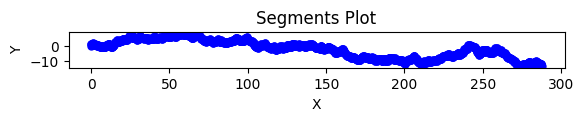

In [7]:
# After training, generate new fake data
z = torch.randn(1, input_size_generator).unsqueeze(1).repeat(1, 855, 1).to(device)  # Generate random noise
fake_data = generator(z)
fake_data = fake_data.view(fake_data.size(0), 855, 2)

generated_data = []

for sample in fake_data:
    segment_data = []
    for vector in sample:
        segment_data.append({
            "length": vector[0].item(),
            "angleToNextVector": vector[1].item()
        })
    generated_data.append({"segments": segment_data})

print(generated_data)

def plot_segments_from_json(data):
    fig, ax = plt.subplots()
    
    for sample in data:
        print("sample", sample)
        segments = sample["segments"]
        x, y = 0, 0  # Starting point
        
        for segment in segments:
            length = segment["length"]
            tmpangle = segment["angleToNextVector"]
            if tmpangle < 0:
                tmpangle = tmpangle + 360
            angle = np.radians(segment["angleToNextVector"])  # Convert angle to radians

            new_x = x + length * np.cos(angle) 
            new_y = y + length * np.sin(angle)*1000
            
            # Plot a line segment from (x, y) to (new_x, new_y)
            ax.plot([x, new_x], [y, new_y], 'bo-', markersize=5)  # 'bo-' for blue line with circle markers

            # Update the current point
            x, y = new_x, new_y

    ax.set_aspect('equal', 'box')
    ax.autoscale()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Segments Plot')
    plt.show()

# Example usage:
plot_segments_from_json(generated_data)




In [ ]:
generator = LSTMGenerator(input_size_generator, hidden_size_generator1, hidden_size_generator2, hidden_size_generator3, output_size_generator)

# After training, generate new fake data
z = torch.randn(1, input_size_generator).unsqueeze(1).repeat(1, 855, 1)  # Generate random noise
fake_data = generator(z)
fake_data = fake_data.view(fake_data.size(0), 855, 2)

generated_data = []

for sample in fake_data:
    segment_data = []
    for vector in sample:
        segment_data.append({
            "length": vector[0].item(),
            "angleToNextVector": vector[1].item()
        })
    generated_data.append({"segments": segment_data})

print(generated_data)

plot_segments_from_json(generated_data)
